# **SUMMARY**

<div class="alert alert-block alert-success">
<b>Adding Monet-like style to photographs with GANs:</b>

* a generative adversarial network was trained on a set of photographs and Monet paintings;
* randomly sampled image batches of size ten, two batches used _per_ epoch, ten training epochs;
* a generator (UNET-like architecture with downsampling convolutions instead of maxsampling) was trained to generate Monet-like paintings from either photographs or real Monet paintings;
* an adversary (discriminator) was trained to correctly identify generated images and real paintings (batch-averaged cross-entropy);
* the generator learns how to produce better Monet's from
    * how well it can cheat the adversary with a generated Monet;
    * how similar (average element-wise difference) is a real Monet to a Monet generated from it;
* this is still a work in progress, but the network generates highly inspired versions of photographs after being trained on a minimal amount of data!
</div>

# **IMPORT PACKAGES**

In [1]:
### IMPORT
### GENERAL PACKAGES
import numpy as np, pandas as pd, statsmodels.api as sm, tensorflow as tf
import os

# MODELS
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt

# **BUILD DATASETS**

## Files

In [2]:
# CHECK FOR INPUT FOLDER AND FILES
fold = !ls /kaggle/input/gan-getting-started/
paintjpeg = !ls /kaggle/input/gan-getting-started/monet_jpg/ | wc -l
painttf = !ls /kaggle/input/gan-getting-started/monet_tfrec/ | wc -l
photojpeg = !ls /kaggle/input/gan-getting-started/photo_jpg/ | wc -l
phototf = !ls /kaggle/input/gan-getting-started/photo_tfrec/ | wc -l
print('Folders: ', fold,'\n',
     'Paintings, jpeg: ', paintjpeg,'\n',
     'Paintings, TFrec: ', painttf,'\n',
     'Photographs, jpeg: ', photojpeg,'\n',
     'Photographs, TFrec: ', phototf)

Folders:  ['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec'] 
 Paintings, jpeg:  ['300'] 
 Paintings, TFrec:  ['5'] 
 Photographs, jpeg:  ['7038'] 
 Photographs, TFrec:  ['20']


<div class="alert alert-block alert-info">
<b>There are four folders containing input files:</b>

* monet_jpg contains 300 painting files in jpeg format - these are training data;
* monet_tfrec contains 5 painting files in tfrec format - these are the same training data as above, in binary format;
* photo_jpg contains 7038 painting files in jpeg format - these are input data for the trained model;
* photo_tfrec contains 20 painting files in tfrec format - these are the same input data as above, in binary format.
***
All files have a 256*256 size.    
We'll work with the jpeg files from now on.    
</div>

## File Integrity

In [3]:
# FINDING AND DELETING CORRUPTED JPEG FILES BASED ON WHETHER THEY HAVE A "JFIF" HEADER
# NUMBER OF CORRUPTED FILES
num_skipped = 0
# GET FILE PATH AND NAME
for folder_name in ('monet_jpg', 'photo_jpg'):
    folder_path = os.path.join('/kaggle/input/gan-getting-started/', folder_name)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # CHECK WHETHER THE JFIF STRING IS IN THE FILE HEADER (STACK)
        try:
            file_obj = open(file_path, "rb")
            # CONVERTS JFIF TO BYTES AND SEARCHES FOR IT IN THE STACK
            is_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
        finally:
            file_obj.close()
        # IF THE JFIF STRING IS NOT IN THE JPEG FILE HEADER INCREMENT NUMEBR OF CORRUPTED FILES
        if not is_jfif:
            num_skipped += 1
            # DELETE CORRUPTED IMAGE
            os.remove(fpath)
# PRINT NUMBER OF CORRUPTED IMAGES
print("Deleted %d images" % num_skipped)

Deleted 0 images


<div class="alert alert-block alert-success">
<b>All jpeg image files are properly encoded!</b>
</div>

## Generate Datasets from JPEG Files

In [4]:
# COPY JPEG FOLDERS TO WORKING DIRECTORY
!cp -r /kaggle/input/gan-getting-started/monet_jpg monet_jpg
!cp -r /kaggle/input/gan-getting-started/photo_jpg photo_jpg
!ls

monet_jpg  photo_jpg


In [5]:
# GENERATE DATASETS FROM THE JPEG FILE DIRECTORIES
ds_monet = tf.keras.utils.image_dataset_from_directory('/kaggle/working/monet_jpg', 
                                                       shuffle=True, color_mode='rgb', labels=None, image_size=(256,256), batch_size=10)
ds_photo = tf.keras.utils.image_dataset_from_directory('/kaggle/working/photo_jpg', 
                                                       shuffle=True, color_mode='rgb', labels=None, image_size=(256,256), batch_size=10)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


## Examples of paintings and photographs in the datasets

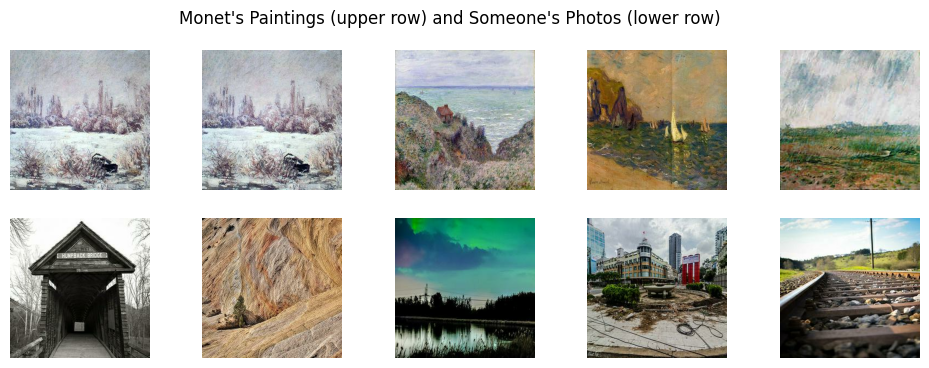

In [6]:
plt.figure(figsize=(12, 4))
for i in range(1,6):
    for im in ds_monet.take(1):
        ax = plt.subplot(2, 5, i)
        plt.imshow(im[i-1].numpy().astype("uint8"))
        plt.axis("off")
#        plt.title(label[0].numpy().astype("uint8"))
        plt.suptitle('Monet\'s Paintings (upper row) and Someone\'s Photos (lower row)')
for i in range(1,6):
    for im in ds_photo.take(1):
        ax = plt.subplot(2, 5, i+5)
        plt.imshow(im[i-1].numpy().astype("uint8"))
        plt.axis("off")
#        plt.title(label[0].numpy().astype("uint8"))
        plt.suptitle('Monet\'s Paintings (upper row) and Someone\'s Photos (lower row)')

# **BUILDING THE MODEL LAYERS**

## Layers: augmentation, donwsampling, upsampling

<div class="alert alert-block alert-info">
<b>Dataset Augmentation:</b>
    
* There is some directionality in image sets;
    * trees and buildings are vertical;
    * the horizon, lake/see surfaces, etc are horizontal;
* Also, there is directionality in the "rules" of painting (perspectives, contrasts, etc), and famous artists often develop their own set of rules;
* Meaning - directionality can mess-up the model; we'll add an option to get rid of it.
***
<b>Downsampling \& Upsampling:</b>

* the UNET network architecture performs a reduction in image size followed by a symmetrical size expansion, resulting in two "branches";
* at each expansion step the layers are concatenated with those from the symmetrical reduction step;
* both sides of the network rely on convolutions with kernels of varying size and number of feature maps.
</div>

In [7]:
# AUGMENTATION AND SCALING
def flip_rot_scale(flip=True,rot=True):
    '''
    Randomly flips the input image around the y axis;
    Randomly rotates the previous image around +/- 20% in the xy plane
    Scales pixel intensities between 0 and 1.
    '''
    result = keras.Sequential()
    if flip:
        result.add(layers.RandomFlip("horizontal"))
    if rot:
        result.add(layers.RandomRotation(0.2))
    result.add(layers.Rescaling(scale=1.0 / 256, offset=0))
    return result

# DOWN SAMPLING
def downsampler(maps, kernel_size, normalization=True, dropout=False):
    '''
    Builds a layer that scales down the input image by a factor of 0.5 in each dimension with a convolution,
    followed by batch normalization and ReLU activation.
    '''
    initializer = tf.random_normal_initializer(0., 0.02)
    # BUILD LAYER
    result = keras.Sequential()
    # DOWNSIZE WITH CONVOLUTION
    result.add(layers.Conv2D(maps, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    # ADD BATCH NORMALIZATION LAYER
    if normalization:
        result.add(layers.BatchNormalization(gamma_initializer=initializer))
    # DROPOUT
    if dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.LeakyReLU(alpha=0.2))
    return result

# UP SAMPLING
def upsampler(maps, kernel_size, normalization=True, dropout=False):
    '''
    Builds a layer that scales up the input image by a factor of 2 in each dimension with a convolution,
    followed by batch normalization and ReLU activation.
    '''
    # INITIALIZERS - NORMAL DISTIBUTION, MEAN=0, STD=0.02
    initializer = tf.random_normal_initializer(0., 0.02)
    # BUILD LAYER
    result = keras.Sequential()
    # ADD UP-SAMPLING CONVOLUTION LAYER
    result.add(layers.Conv2DTranspose(maps, kernel_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    # ADD BATCH NORMALIZATION LAYER
    if normalization:
        result.add(layers.BatchNormalization(gamma_initializer=initializer))
    # DROPOUT
    if dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.LeakyReLU(alpha=0.2))
    return result

# **BUILDING THE GAN UNITS**

## Generator: based on UNET

<div class="alert alert-block alert-info">
<b>UNET architecture:</b>
    
* This is a simplified version of UNET, with a smaller number of feature maps and convolution steps
* Still, the principle is the same
    * downsampling to 4x4 feature maps through padded convolutions with kernels from 7x7 to 3x3 size;
    * upsampling to 256x256 feature maps through padded convolutions with kernels from 3x3 to 5x5 size;
    * upsampling feature maps are concatenated with same-sized downsampled maps;
* Large kernel sizes are employed to try to capture the characteristic long-range correlations in Monet's "diffuse" style.
</div>

In [8]:
def generator():
    # INSTANTIATE INPUT
    inp = layers.Input(shape=[256,256,3])
    xdown= inp
    initializer = tf.random_normal_initializer(0., 0.02)

    # AUGMENT AND/OR SCALE DATA 
    flip_rot_scale(flip=True,rot=True)(xdown)
    # DOWNSCALE THE PHOTOGRAPHS WITH CONVOLUTIONS; OUTPUT DIMENSIONS ARE (4x4x512)
    downscaling = [downsampler(64,7,normalization=False),downsampler(128,7),downsampler(256,5),
                   downsampler(512,5),downsampler(512,3),downsampler(512,3)]
    samples=[]
    for d in downscaling:
        xdown= d(xdown)
        samples.append(xdown)
    # UPSCALE IMAGES WITH CONVOLUTIONS; OUTPUT IMAGE DIMENSIONS = (256,256,128)
    xup = xdown
    upscaling = [upsampler(512,3),upsampler(512,3),upsampler(256,5),upsampler(128,5),upsampler(64,5)]
    # CREATE LIST OF SAMPLES DO BE CONCATENATED
    selpmas = reversed(samples[:-1])
    for u,s in zip(upscaling, selpmas):
        xup = u(xup)
        xup = layers.Concatenate()([xup,s])
    # UPSAMPLING WITHOUT CONCATENATION; OUTPUT SIZE (256,256,256)
    xup = upsampler(512,5)(xup)
    # TO IMAGE; OUTPUT IMAGE SIZE = (256,256,3)
    # SIGMOID ACTIVATION MAY BE TOO SHARP FOR MID-INTENSITY PIXELS, YIELDING STRONG CONTRASTS UNCHARACTERISTIC OF MONET;
    # WE'LL HAVE TO SEE...
    xup = layers.Conv2D(3, 3, strides=1, padding='same', kernel_initializer=initializer, activation='sigmoid')(xup)
    # OUTPUT
    return keras.Model(inputs=inp, outputs=xup)

## Discriminator

<div class="alert alert-block alert-info">
<b>Architecture:</b>
    
* downsample an input painting to a single 32x32 feature maps through padded convolutions with kernels from 7x7 to 3x3 size;
* build a final 32x32 evaluation map with a padded convolution (3x3 kernel);
</div>

In [9]:
def discriminator():
    # INSTANTIATE INPUT
    inp = layers.Input(shape=[256,256,3])
    xdown= inp
    initializer = tf.random_normal_initializer(0., 0.02)

    # DOWNSCALE THE IMAGES WITH CONVOLUTIONS; FINAL DIMENSIONS OF EACH PHOTO IN A 5-PHOTO BATCH ARE (32,32,512)
    downscaling = [downsampler(128,7),downsampler(256,5),downsampler(512,3)]
    # GETTING DOWNSCALED MAPS OF THE PHOTOS
    for d in downscaling:
        xdown= d(xdown)
    # CONVOLUTIONS WITHOUT DOWNSAMPLING: 32x32x512 WITH 0.5 DROPOUT
    xdown = layers.Conv2D(256, 3, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(xdown)
    #xdown = layers.Dropout(0.5)(xdown)
    xdown = layers.BatchNormalization(gamma_initializer=initializer)(xdown)
    xdown = layers.LeakyReLU(alpha=0.2)(xdown)
    # TO EVALUATION MAP: 32x32x1
    xdown = layers.Conv2D(1, 3, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(xdown)
    # OUTPUT
    return keras.Model(inputs=inp, outputs=xdown)

# **ASSEMBLING THE GAN**

<div class="alert alert-block alert-info">
<b>The GAN:</b>
    
* Make use of the Keras.Model class to build a GAN class (subclassing from Model)
    * take the generator and discriminator as the model's layers;
    * set compile with ADAM optimizer and custom loss functions;
    * set forward pass (the training step)
</div>

## Subclassing a model: layers, compiler, call

In [10]:
class Gan(keras.Model):
    # MODEL LAYERS
    def __init__(self, generator, discriminator):
        super().__init__()
        self.monet_gen = generator
        self.monet_disc = discriminator
        
    # MODEL COMPILATION METHOD FROM KERAS
    # LOSS FUNTIONS ARE SET IN THE CELL BELOW
    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, gen_identity_loss, disc_loss_fn):
        super().compile()
        self.gen_opt = gen_optimizer
        self.disc_opt = disc_optimizer
        self.gen_loss = gen_loss_fn
        self.id_loss = gen_identity_loss
        self.disc_loss = disc_loss_fn
    
    # CUSTOM MODEL TRAINING
    def train_step(self, data):
        # REMEMBER: BATCHES HAVE SHUFFLE=YES, MEANING THEY ARE ASSEMBLED RANDOMLY WHENEVER data IS CALLED
        real_photo, real_monet = data
        # TRAIN DISCRIMINATOR
        with tf.GradientTape(persistent=False) as disc_tape:
            # GENERATING MONETS
            pic_to_monet = self.monet_gen(real_photo)
            # DISCRIMINATING REAL AND FAKE MONETS
            disc_real_monet = self.monet_disc(real_monet)
            disc_fake_monet = self.monet_disc(pic_to_monet)
            # DISCRIMINATOR LOSS
            disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
        # CALCULATE AND APPLY DISCRIMINATOR GRADIENT
        disc_grad = disc_tape.gradient(disc_loss, self.monet_disc.trainable_weights)
        self.disc_opt.apply_gradients(zip(disc_grad, self.monet_disc.trainable_weights))
        # TRAIN GENERATOR
        with tf.GradientTape(persistent=False) as gen_tape:
            # GENERATING MONETS
            monet_to_monet = self.monet_gen(real_monet)
            # GENERATOR LOSS; THE ID_LOSS YIELDS A LARGE ENOUGH VALUE TO DRIVE THE 
            # GRADIENT OPTIMIZATION EVEN WHEN THE DISCRIMINATOR IS CONFUSED
            gen_loss = self.gen_loss(disc_fake_monet) + self.id_loss(real_monet, monet_to_monet)
        # CALCULATE AND APPLY GENERATOR GRADIENT
        gen_grad = gen_tape.gradient(gen_loss, self.monet_gen.trainable_weights)
        self.gen_opt.apply_gradients(zip(gen_grad, self.monet_gen.trainable_weights))
        
        # RETURN LOSS VALUES
        return {"Generator loss": gen_loss, "Discriminator Loss": disc_loss}

## Loss Functions

<div class="alert alert-block alert-info">
<b>Loss Functions:</b>
    
* Discriminator loss averages 
    * the comparison (cross-entropy) between a real Monet to the ideal "real" evaluation map from the discriminator (an all=ones matrix);
    * the comparison (cross-entropy) between a generated Monet and the ideal "fake" evaluation map from the discriminator (an all=zeroes matrix);
* Generator loss sums
    * the discriminator's evaluation map for a generated Monet compared to an all-ones map (cross-entropy); an all-ones evaluation map from a generated Monet would mean the discriminator is entirely fooled;
    * the mean element-wise difference between a real Monet and a Monet generated from that same real Monet (how well can the generator re-generate an image).
</div>

In [11]:
def disc_loss_fn(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5
    
def gen_loss_fn(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)
    
def gen_identity_loss(real_image, same_image):
    # GENERATOR OUTPUTS ARE IN THE INTERVAL [0,1], AND SHOULD BE SCALED
    same_image = layers.Rescaling(scale=256, offset=0)(same_image)
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

# **RUNNING THE GAN**

## Compile and Fit

In [12]:
%%time
model = Gan(discriminator=discriminator(), generator=generator())

model.compile(gen_optimizer=keras.optimizers.Adam(),
                 disc_optimizer=keras.optimizers.Adam(),
                 gen_loss_fn=gen_loss_fn,
                 gen_identity_loss=gen_identity_loss,
                 disc_loss_fn=disc_loss_fn)

model.fit(tf.data.Dataset.zip((ds_photo.take(5), ds_monet.take(5))), epochs=10)

Epoch 1/10
5/5 [==============================] - 222s 43s/step - Generator loss: 27.0977 - Discriminator Loss: 0.6931
Epoch 2/10
5/5 [==============================] - 215s 43s/step - Generator loss: 24.6904 - Discriminator Loss: 0.6931
Epoch 3/10
5/5 [==============================] - 214s 43s/step - Generator loss: 22.6356 - Discriminator Loss: 0.6926
Epoch 4/10
5/5 [==============================] - 215s 43s/step - Generator loss: 21.7658 - Discriminator Loss: 0.6792
Epoch 5/10
5/5 [==============================] - 215s 43s/step - Generator loss: 20.3391 - Discriminator Loss: 0.4757
Epoch 6/10
5/5 [==============================] - 214s 43s/step - Generator loss: 19.1552 - Discriminator Loss: 0.2864
Epoch 7/10
5/5 [==============================] - 215s 43s/step - Generator loss: 20.6879 - Discriminator Loss: 0.1901
Epoch 8/10
5/5 [==============================] - 215s 43s/step - Generator loss: 21.4169 - Discriminator Loss: 0.0557
Epoch 9/10
5/5 [==============================] 

<div class="alert alert-block alert-danger">
<b>Current notes on network tweaks and optimization:</b>
    
* Discriminator loss drops very fast after a couple of epochs
    * set final discriminator convolution to 128 channels?
* Monet is fuzzier
    * change kernel sizes?
* change backprop to also work on biases?
</div>

## Admire the Paintings

2/2 [==============================] - 19s 9s/step


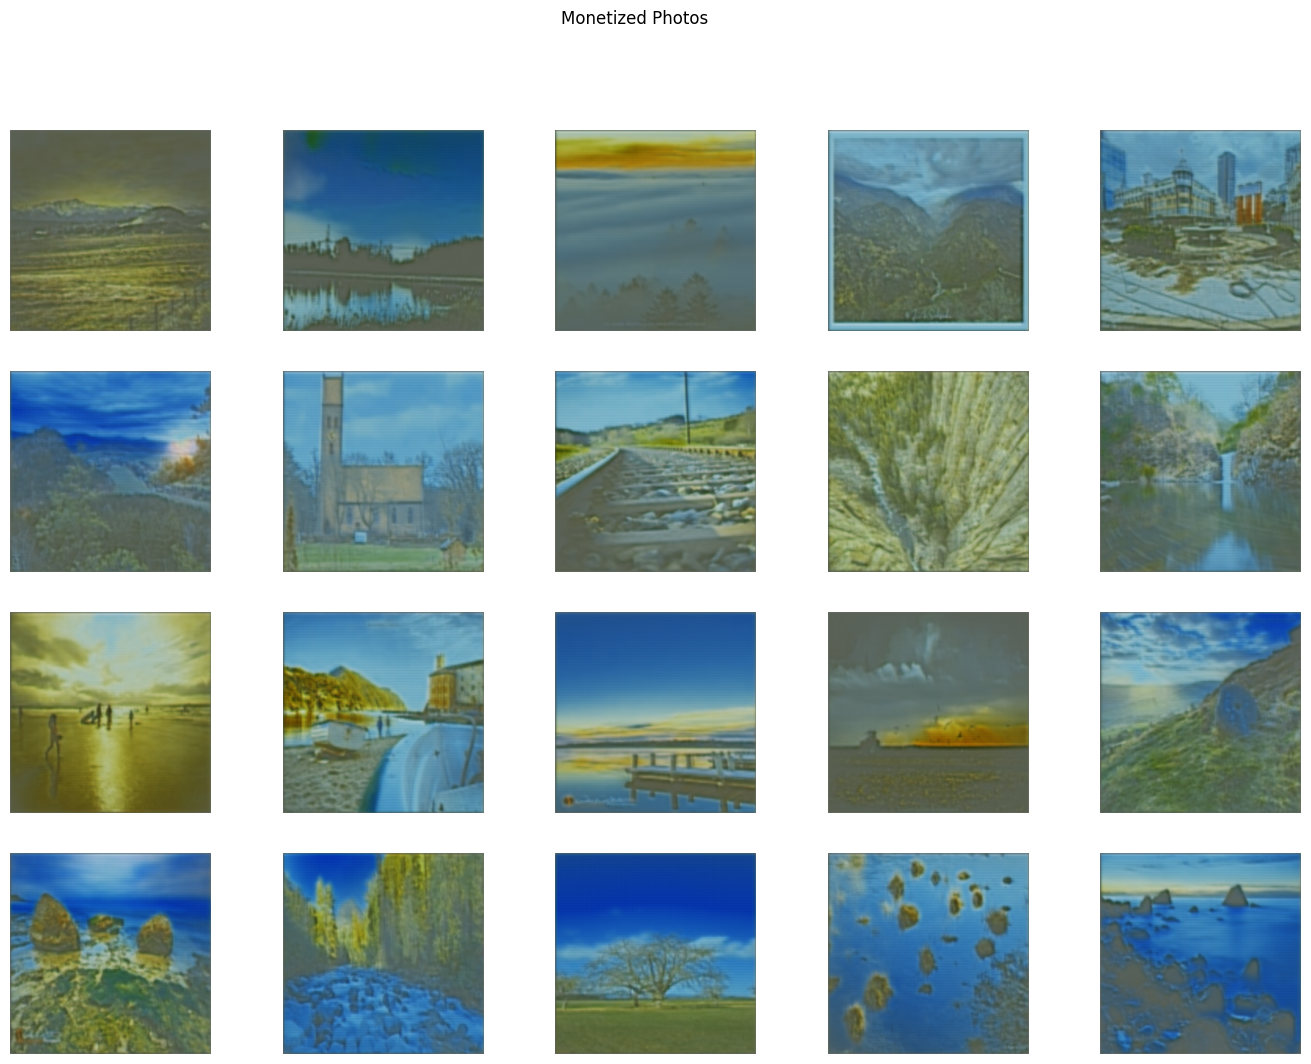

In [13]:
trained_gen = model.monet_gen
output = trained_gen.predict(ds_photo.take(2))
plt.figure(figsize=(17, 12))
for i in range(1,21):
    ax = plt.subplot(4, 5, i)
    img=output[i-1]*256
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.suptitle('Monetized Photos')

<div class="alert alert-block alert-success">
<b>About the success of the whole operation:</b>

* the network was trained on 50 photos for 10 epochs;
* the network is not yet optimized for performance, hardware, etc;
    * it takes about 4.5 seconds to train on a single photo;
    * it takes 1.25 seconds for the trained network to generate a painting;
* the "paintings" are still far from the desired outcome; still, considering the number of training samples, they're pretty good!
</div>